In [1]:
"""
This program is for analysis of
muon decays events
"""
import sys
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import iminuit
import probfit
import uproot
from tqdm.notebook import tqdm, tnrange
# from pkgs.fit.fit import sigmoid
from scipy import integrate
import ROOT
from ROOT import TH1F, TCanvas, TF1
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
expo = """
double expon(double *x, double *par)
{
return par[0] * TMath::Exp(-1.0 * x[0]/ par[1]);
};
"""
ROOT.gInterpreter.Declare(expo)

True

In [3]:
# We want to speed things up with Cython
%load_ext Cython

In [4]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3

In [9]:
def analysis(raw_data):
    debug = False
    n_events = raw_data.size
    n_per_event = raw_data[0].size
    timesteps = np.arange(0, n_per_event, 1)
    raw_data = np.negative(raw_data)
    maxs = []
    for m in(raw_data):
        maxs.append(np.max(m))

    risetimes = []
    t1s = []
    t2s = []
    evt = []
    integrals = []
    raw_integrals = []
    print(f'Total number of events: {n_events}')

#     for i in tqdm(range(n_events)):
    for i in tnrange(n_events):
        # smoothed_data = smooth(raw_data[i], window_len=51, window='bartlett')
        smoothed_data = signal.savgol_filter(raw_data[i], 51, 3)
        data = np.concatenate((timesteps[:, np.newaxis],
                               smoothed_data[:n_per_event, np.newaxis]), axis=1)
        peak_range = [0.2, data[:, 1].max()]  # cut for two peaks
        peaks, properties = signal.find_peaks(data[:, 1],
                                              height=peak_range, distance=300)
        results_w = signal.peak_widths(data[:, 1], peaks, rel_height=0.95)
        try:
            i1_raw =  integrate.simps(raw_data[i][int(results_w[2][0]):peaks[0]], timesteps[int(results_w[2][0]):peaks[0]])
            i2_raw =  integrate.simps(raw_data[i][int(results_w[2][1]):peaks[1]], timesteps[int(results_w[2][1]):peaks[1]])
            raw_integrals.append([i1_raw, i2_raw])
        except Exception as e:
                print(str(e))
        # and data[peaks[0], 1] > data[peaks[1], 1]
        if len(peaks) >= 2  and data[:, 1].max() < np.max(maxs)-0.01 and peaks[1] < 9000:
            peaks_start = [int(p) for p in (results_w[2])]
            ranged_sm_p1 = data[peaks_start[0]:peaks[0]]
            ranged_sm_p2 = data[peaks_start[1]:peaks[1]]
            temp_times = []
            """
            Calculating Integrals
            """
            i1 = integrate.simps(ranged_sm_p1[:, 1], ranged_sm_p1[:, 0])
            i2 = integrate.simps(ranged_sm_p2[:, 1], ranged_sm_p2[:, 0])
            
            
            integrals.append([i1, i2])
            
            """
            Fitting first peak:
            """
            t1 = np.arange(0, ranged_sm_p1[:, 0].size)
            chi2_fit = probfit.Chi2Regression(
                sigmoid,
                # t1,
                ranged_sm_p1[:, 0],
                ranged_sm_p1[:, 1],
            )

            minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(ranged_sm_p1[:, 1]),
                p1=np.mean(ranged_sm_p1[:, 0]),
                # p1=peaks[0],
                # p1=t1.max(),
                p3=np.min(ranged_sm_p1[:, 1]),
                #limit_p3=(np.min(data[a : peaks[0], 1]), None),
                pedantic=False,
                print_level=-1,
            )
            minuit.migrad()
            try:
                minuit.hesse()
            except Exception as e:
#                 print(str(e))
                pass
            p = minuit.values
            tz1 = p[1] - np.log(p[0] / (0.2 * ranged_sm_p1[:, 1].max() - p[3]) - 1.0) / p[2]
            temp_times.append(tz1)
            """
            Fitting second peak
            """
            t2 = np.arange(0, ranged_sm_p2[:, 0].size)
            chi2_fit_p2 = probfit.Chi2Regression(
                sigmoid,
                # t2,
                ranged_sm_p2[:, 0],
                ranged_sm_p2[:, 1],
            )
            
            minuit_p2 = iminuit.Minuit(
                chi2_fit_p2,
                #                 p0=np.max(data[b : peaks[1], 1]),
                p1=np.mean(ranged_sm_p2[:, 0]),
                # limit_p1=(t2.max()/2, t2.max()),
                p3=np.min(ranged_sm_p2[:, 1]),
                #                 limit_p3=(np.min(data[b : peaks[1], 1]), None),
                #                 fix_p3=np.min(data[b : peaks[1], 1]),
                pedantic=False,
                print_level=-1,
            )
            
            minuit_p2.migrad()
            try:
                minuit_p2.hesse()
            except Exception as e:
                print(str(e))
                
            pp = minuit_p2.values
            tz2 = pp[1] - np.log(pp[0] / (0.2 * ranged_sm_p2[:, 1].max() - pp[3]) - 1.0) / pp[2]
            temp_times.append(tz2)
            risetimes.append([temp_times[0], temp_times[1]])
            evt.append(i)
            t1s.append(temp_times[0])
            t2s.append(temp_times[1])

            if debug == True:
                print(f'The value of the variable p0 is {minuit.values["p0"]}')
                print(f'The value of the variable p1 is {minuit.values["p1"]}')
                print(f'The value of the variable p2 is {minuit.values["p2"]}')
                print(f'The value of the variable p3 is {minuit.values["p3"]}')
                print(tz1, tz2)
                print(risetimes)
                plt.figure(figsize=(25, 7))
                chi2_fit_p2.draw(minuit_p2)
                plt.show()

    return (evt, t1s, t2s, integrals, raw_integrals)


In [10]:
files = ["oscil_191216.root", "mudecays824.root", "muon_191218/oscill_191218.root"]
rel_path = "../../Labs/muon_decay/"
filename = rel_path + files[1]

In [11]:
tree_names = ["t1", "tree"]
for t_n in tree_names:
    try:
        df_np = uproot.open(filename)[t_n].array("channel1")
        break
    except Exception as ex:
        print(ex)

ev, tz1, tz2, ints, raw_ints = analysis(df_np)
tz1 = np.asarray(tz1)
tz2 = np.asarray(tz2)
times = np.concatenate((tz1[:, np.newaxis], tz2[:, np.newaxis]), axis=1)
np.savetxt(f'{filename[:-5]}_events.log', ev, fmt='%1i')

diffs = tz2 - tz1
t_step_per_point = 4 * 1e-04 # in μs
diffs *= t_step_per_point

Total number of events: 824


index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with size 1
index 1 is out of bounds for axis 0 with

In [13]:
print(f'Found {len(ev)} events')
print(ev)

Found 367 events
[1, 2, 3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 19, 20, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 58, 62, 63, 64, 65, 66, 67, 69, 71, 72, 73, 74, 75, 78, 79, 80, 83, 84, 85, 86, 87, 88, 90, 91, 94, 95, 96, 97, 99, 100, 101, 104, 105, 107, 108, 109, 110, 111, 113, 115, 117, 118, 120, 121, 122, 123, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 139, 141, 142, 143, 144, 145, 146, 147, 149, 151, 153, 154, 155, 156, 158, 159, 160, 161, 163, 164, 165, 166, 167, 170, 171, 172, 174, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 189, 190, 192, 193, 195, 196, 197, 199, 200, 202, 203, 206, 209, 210, 211, 212, 215, 217, 218, 220, 221, 223, 224, 226, 227, 229, 231, 232, 233, 234, 235, 375, 378, 380, 382, 386, 387, 388, 389, 391, 393, 394, 395, 396, 400, 401, 402, 403, 404, 405, 406, 407, 411, 412, 413, 414, 417, 418, 419, 421, 425, 426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 441, 444, 445, 448, 45

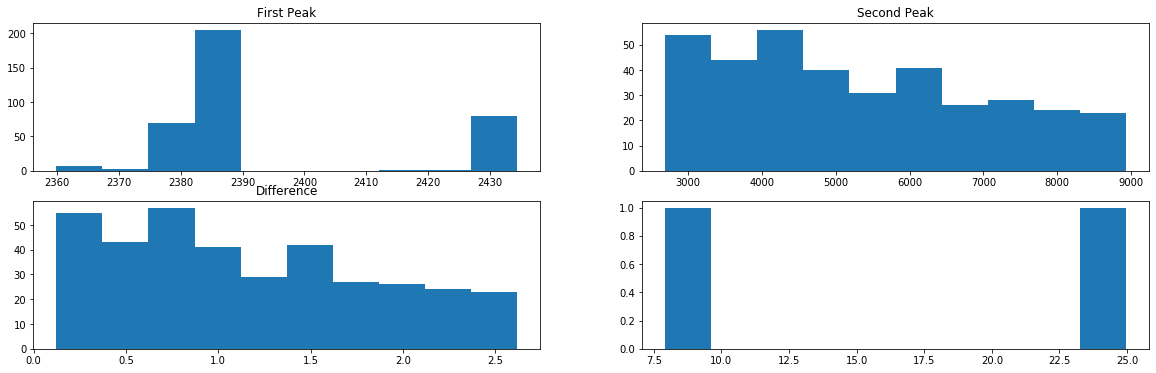

In [14]:
plt.figure(figsize=(20,6))
plt.subplot(221)
plt.hist(times[:, 0])
plt.title("First Peak")
plt.subplot(222)
plt.hist(times[:, 1])
plt.title("Second Peak")
plt.subplot(223)
plt.hist(diffs)
plt.title("Difference")
plt.subplot(224)
plt.hist(ints[0])
plt.show()

 FCN=90.7234 FROM MIGRAD    STATUS=CONVERGED      37 CALLS          38 TOTAL
                     EDM=2.19626e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.61843e+00   1.23364e-01   2.84476e-04  -3.38591e-03
   2  Slope       -4.05107e-01   9.28639e-02   2.14052e-04  -4.33126e-03


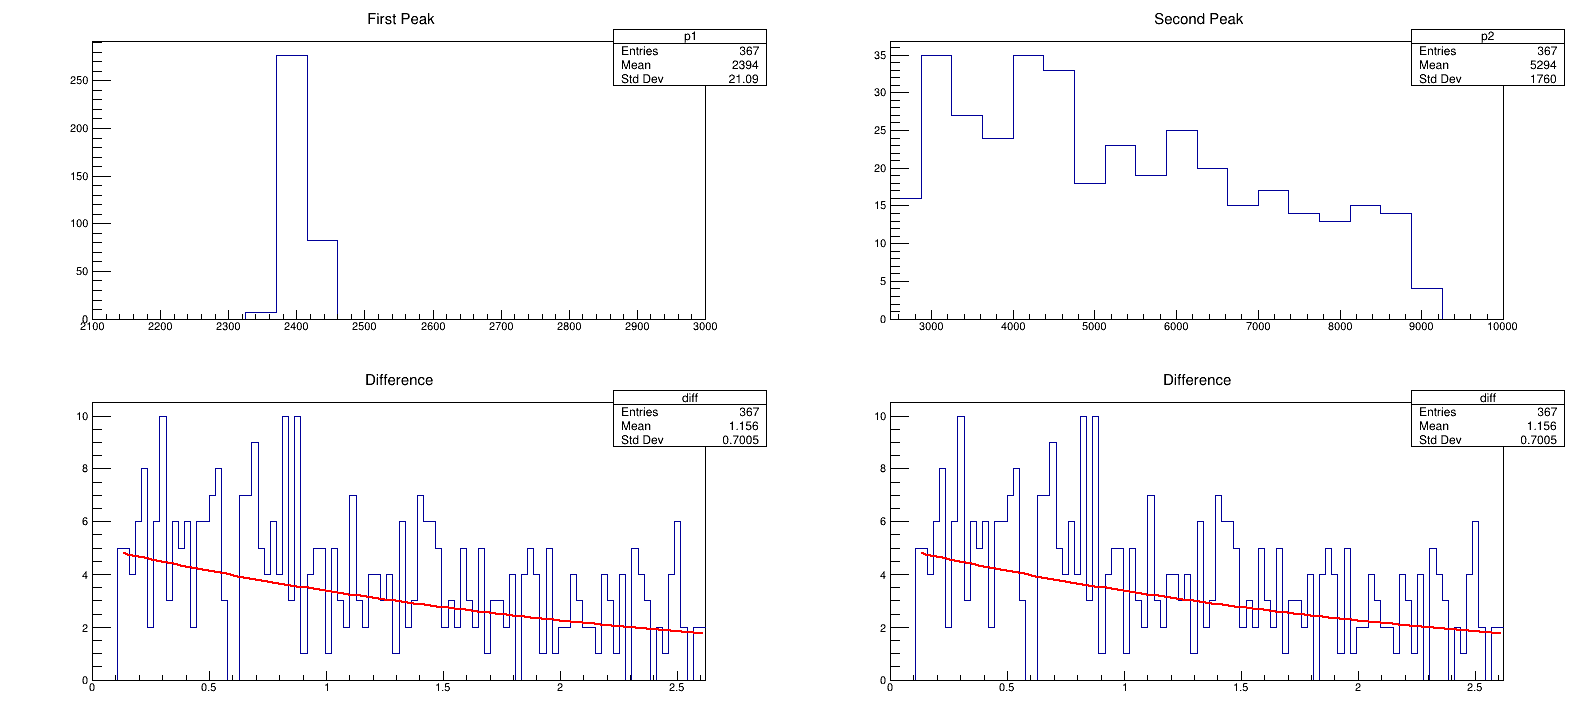

In [15]:
# fit_exp = TF1("fit_exp", ROOT.expon, diffs.min(), diffs.max(), 2)
# fit_exp = TF1("fit_exp", ROOT.expon, 500, 2000, 2)
fit_exp = TF1("fit_exp", "expo", diffs.min(), diffs.max(), 2)
fit_exp.SetParameter(0, 6)
fit_exp.SetParameter(1, 1e-03)
c1 = TCanvas("Histograms", "test", 1600,750)
c1.Divide(2, 2)
p1 = TH1F("p1", " First Peak", 20, 2100, 3000)
p2 = TH1F("p2", " Second Peak", 20, 2500, 10000)
diff = TH1F("diff", "Difference", 100, 0, diffs.max())
# diff = TH1F("diff", "Difference", diffs.size, 0, diffs.max())
# for i in range(diffs.size):
#     diff.SetBinContent(i+1, diffs[i])
for i in range(tz1.size):
    p1.Fill(tz1[i])
    p2.Fill(tz2[i])
    diff.Fill(diffs[i])
c1.cd(1)
p1.Draw()
c1.cd(2)
p2.Draw()
c1.cd(3)
diff.Draw()
c1.cd(4)
diff.Fit(fit_exp, "R")
c1.Draw()
c1.Update()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Histograms


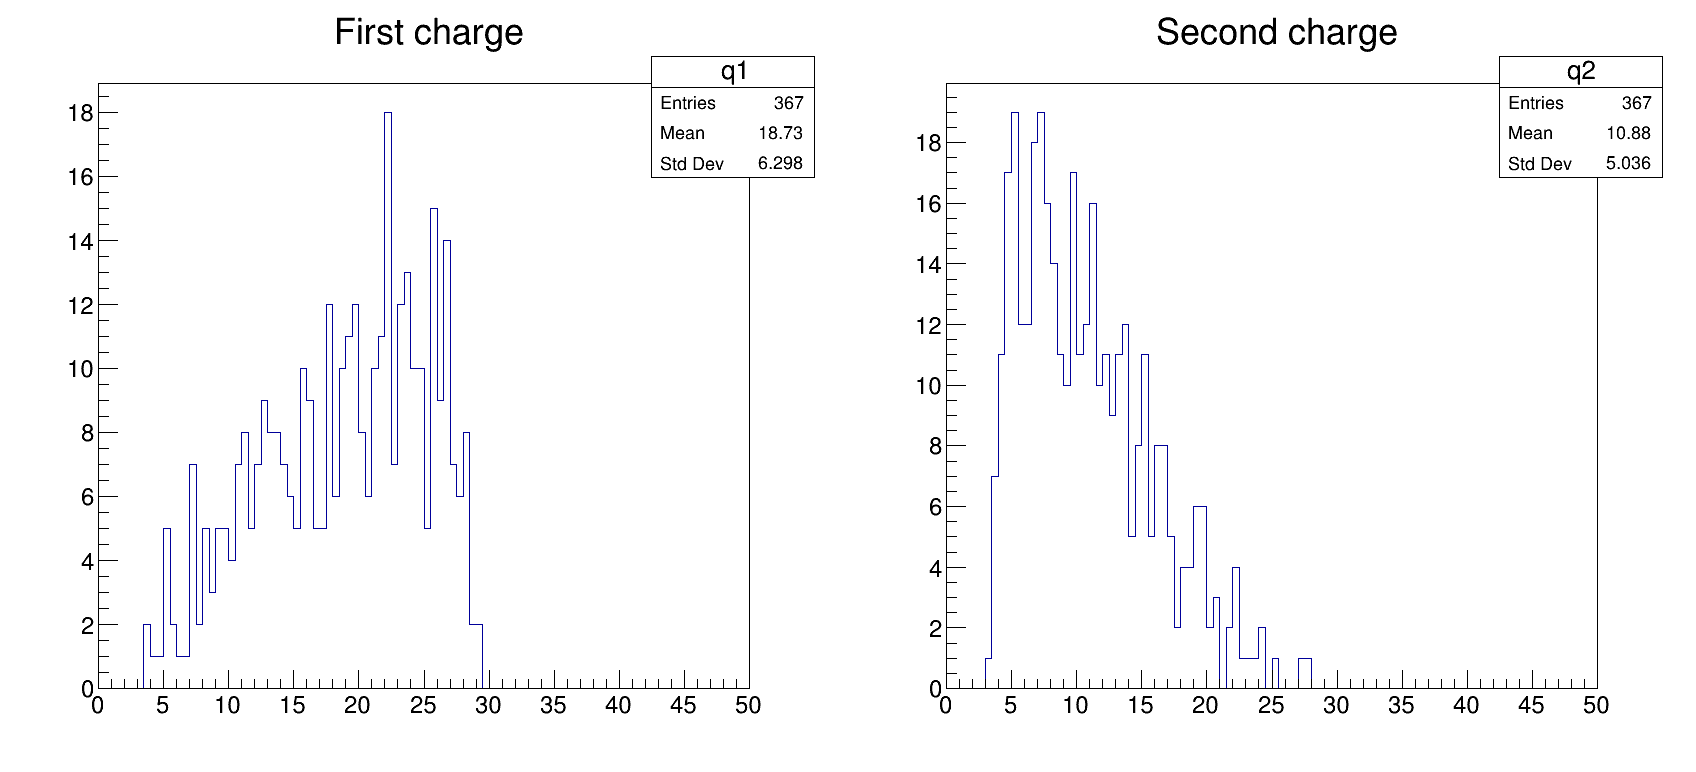

In [16]:
c2 = TCanvas("Histograms", "test", 1700,800)
c2.Divide(2)
q1 = TH1F("q1", " First charge", 100, 0, 50)
q2 = TH1F("q2", " Second charge", 100, 0, 50)
for i in range(len(ev)):
    q1.Fill(ints[i][0])
    q2.Fill(ints[i][1])
c2.cd(1)
q1.Draw()
c2.cd(2)
q2.Draw()
c2.Draw()
c2.Update()

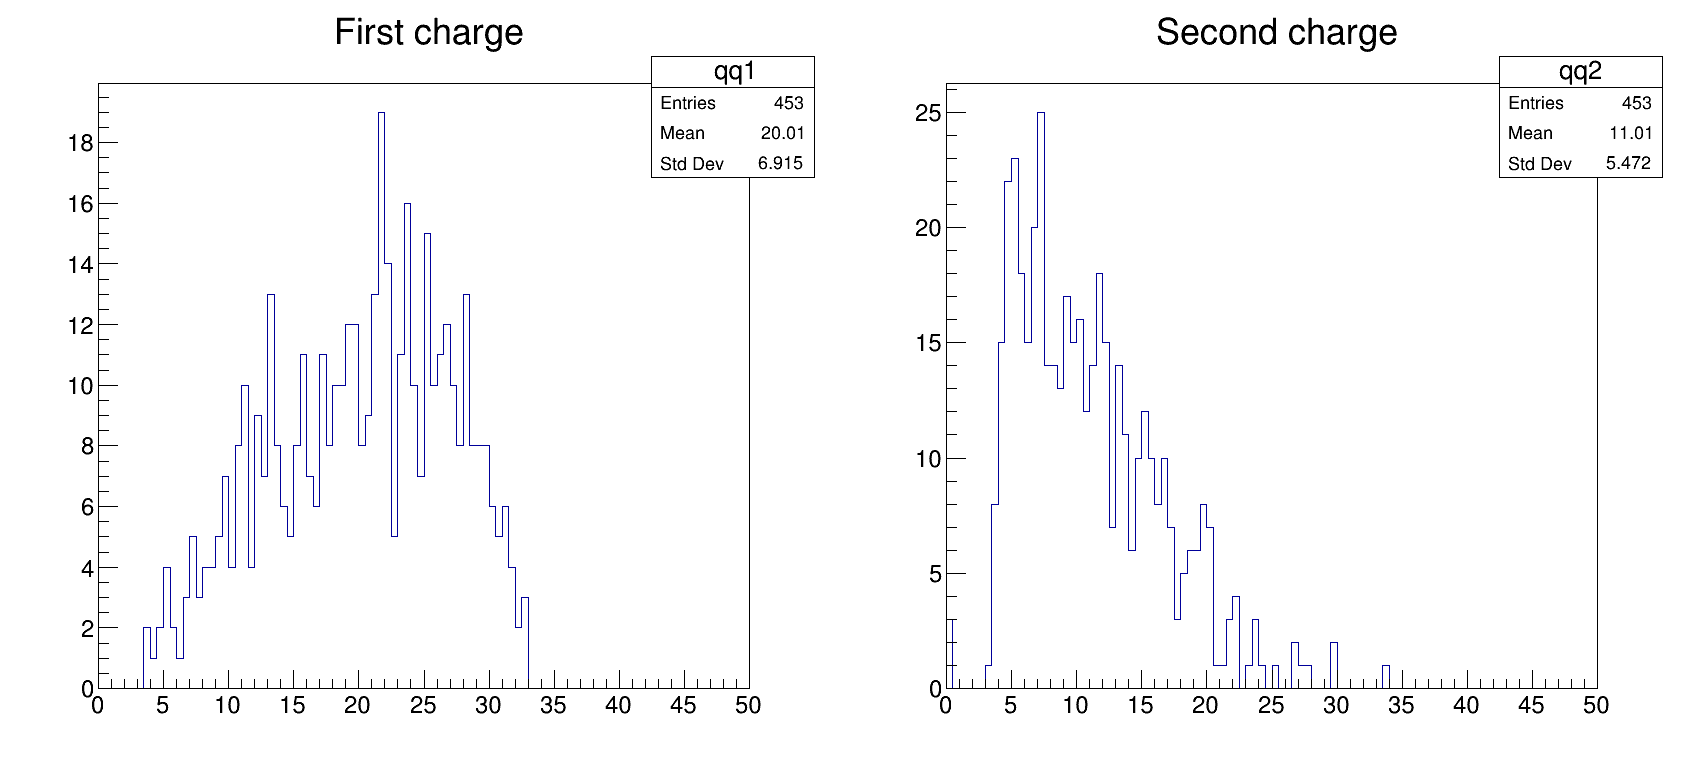

In [17]:
c3 = TCanvas("c3", "test", 1700,800)
c3.Divide(2)
qq1 = TH1F("qq1", " First charge", 100, 0, 50)
qq2 = TH1F("qq2", " Second charge", 100, 0, 50)
for i in range(len(raw_ints)):
    qq1.Fill(raw_ints[i][0])
    qq2.Fill(raw_ints[i][1])
c3.cd(1)
qq1.Draw()
c3.cd(2)
qq2.Draw()
c3.Draw()
c3.Update()

In [18]:
1/4.05107e-01

2.4684836351877406

In [ ]:
1/0.367406